##Proyecto: Daily total female births in California, 1959


José Luis Corona Gómez

El dataset es una serie de tiempo que representa el número total de nacimientos de niñas registrados en California, EE. UU., durante el año 1959.

Mediante un modelo LSTM intentaremos predecir los nacimientos

In [35]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout

data = pd.read_csv('/content/daily-total-female-births-CA.csv', parse_dates=['date'], index_col='date')
births = data['births'].values.reshape(-1, 1)



In [36]:
# Normalizar datos
scaler = MinMaxScaler()
births_normalized = scaler.fit_transform(births)

# sec temporales (ventana de 14 días)
def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(births_normalized)

#Split 80-20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


##Justificación

*   Los modelos LSTM son preferibles a la hora de trabajar con datos con estructura de serie de tiempo.
*   Los modelos LSTM pueden mantener información por períodos largos, evitando el desvanecimiento del gradiente


*   Pueden aprender patrones estacionales






In [37]:

 #modelo LSTM

model = Sequential([
    LSTM(64, activation='tanh',
      return_sequences=True,
        input_shape=(X_train.shape[1], 1)),#corto y mediano plazo.
    Dropout(0.2),#evitar sobre ajuste
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0685 - val_loss: 0.0201
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0206 - val_loss: 0.0216
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0257 - val_loss: 0.0204
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0187 - val_loss: 0.0198
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0277 - val_loss: 0.0223
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0209 - val_loss: 0.0198
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0239 - val_loss: 0.0198
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0246 - val_loss: 0.0194
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0215 - val_loss: 0.0201
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0233 - val_loss: 0.0194
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0238 - val_loss: 0.0194
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

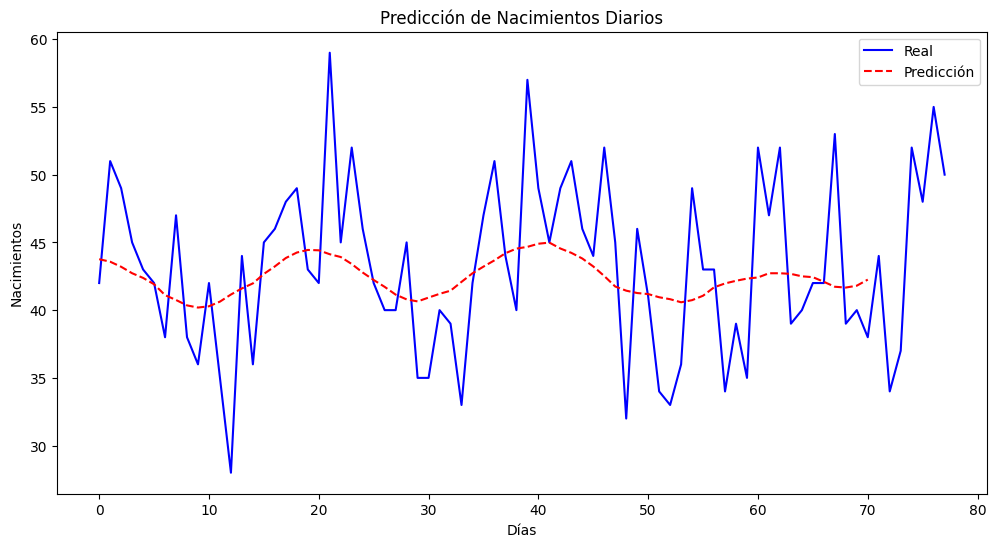

Primeros 10 valores reales vs predichos:

Real: 42.00 - Predicho: 43.76
Real: 51.00 - Predicho: 43.58
Real: 49.00 - Predicho: 43.20
Real: 45.00 - Predicho: 42.72
Real: 43.00 - Predicho: 42.38
Real: 42.00 - Predicho: 41.91
Real: 38.00 - Predicho: 41.11
Real: 47.00 - Predicho: 40.75
Real: 38.00 - Predicho: 40.35
Real: 36.00 - Predicho: 40.19


In [38]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#Entrenar
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=1
)

#Predicciones
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

def create_raw_targets(data, window_size=7):
    y_raw = []
    for i in range(len(data) - window_size):
        y_raw.append(data[i+window_size])
    return np.array(y_raw)

births_raw = data['births'].values
y_full_raw = create_raw_targets(births_raw)
y_test_raw = y_full_raw[split:]  # Esta es la parte de test

# 9. Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_raw, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')
plt.title('Predicción de Nacimientos Diarios')
plt.xlabel('Días')
plt.ylabel('Nacimientos')
plt.legend()
plt.show()

# 10. Mostrar comparaciones reales vs predichos
print("Primeros 10 valores reales vs predichos:\n")
for real, pred in zip(y_test_raw[:10], y_pred[:10]):
    print(f"Real: {real:.2f} - Predicho: {pred[0]:.2f}")
